In [1]:
import os
os.chdir('/project/ssverma_shared/projects/Endometriosis/Endo_Subtyping_Heterogeneity/Cluster_Training/')
import pandas as pd
import matplotlib as mpl
import numpy as np
np.seterr(divide = 'ignore')


mpl.rcParams['figure.dpi'] = 120

%config IPCompleter.use_jedi = False
%matplotlib inline

In [2]:
import numpy as np

from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
import seaborn as sns
import pickle

ModuleNotFoundError: No module named 'upsetplot'

In [ ]:
# Set up color palette to use for the five clusters
colors = ['fuchsia',
          'darkviolet',
          'navy',
          'dodgerblue',
          'mediumspringgreen',
          'g']

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)

for i in range(len(colors)):
    plt.plot([0, 1], [i, i])

plt.show()

In [ ]:
# Check if Snakemake files are up-to-date
! snakemake -n all --quiet

In [ ]:
features = pd.read_csv('Data/non_genotyped_PMBB_data_for_no_snps_clustering.csv', index_col='IID', dtype={'IID': str})

In [ ]:
pheno = pd.read_csv('Pheno/FULL_PMBB_all_cleaned_phenos.csv', index_col='PMBB_ID', low_memory=False)
pheno = pheno.loc[features.index]

pheno[[c for c in pheno.columns if 'CC3' in c]] = pheno[[c for c in pheno.columns if 'CC3' in c]].apply(lambda x: pd.to_numeric(x, errors='coerce'))

use_pheno = 'ICD_1_with_N80.0'

cases = pheno.index[pheno[use_pheno] == 1]
controls = pheno.index[pheno[use_pheno] == 0]

cases = cases.intersection(features.index)

pheno = pheno[pheno.index.isin(cases) | pheno.index.isin(controls)]

print(len(controls), len(cases))

pheno[use_pheno].fillna('NA').value_counts()

In [ ]:
view_cols = ['CC1_ALL', 'CC2_ALL', 'CC1_RA', 'CC2_RA',
             'CC1_ALL_with_N80.0', 'CC2_ALL_with_N80.0', 'CC1_RA_with_N80.0', 'CC2_RA_with_N80.0',
             'ICD_1', 'ICD_2', 'ICD_1_with_N80.0', 'ICD_2_with_N80.0',
             'endometriosis', 'uterine_endometriosis', 'not_uterine_endometriosis',
             'CC1_ALL_with_N80.0_with_US', 'CC2_ALL_with_N80.0_with_US',
             'CC1_RA_with_N80.0_with_US', 'CC2_RA_with_N80.0_with_US']

pheno[view_cols].fillna('NA').apply(lambda x: x.value_counts(), result_type='expand').transpose().fillna(0).sort_values(by=1, ascending=False)

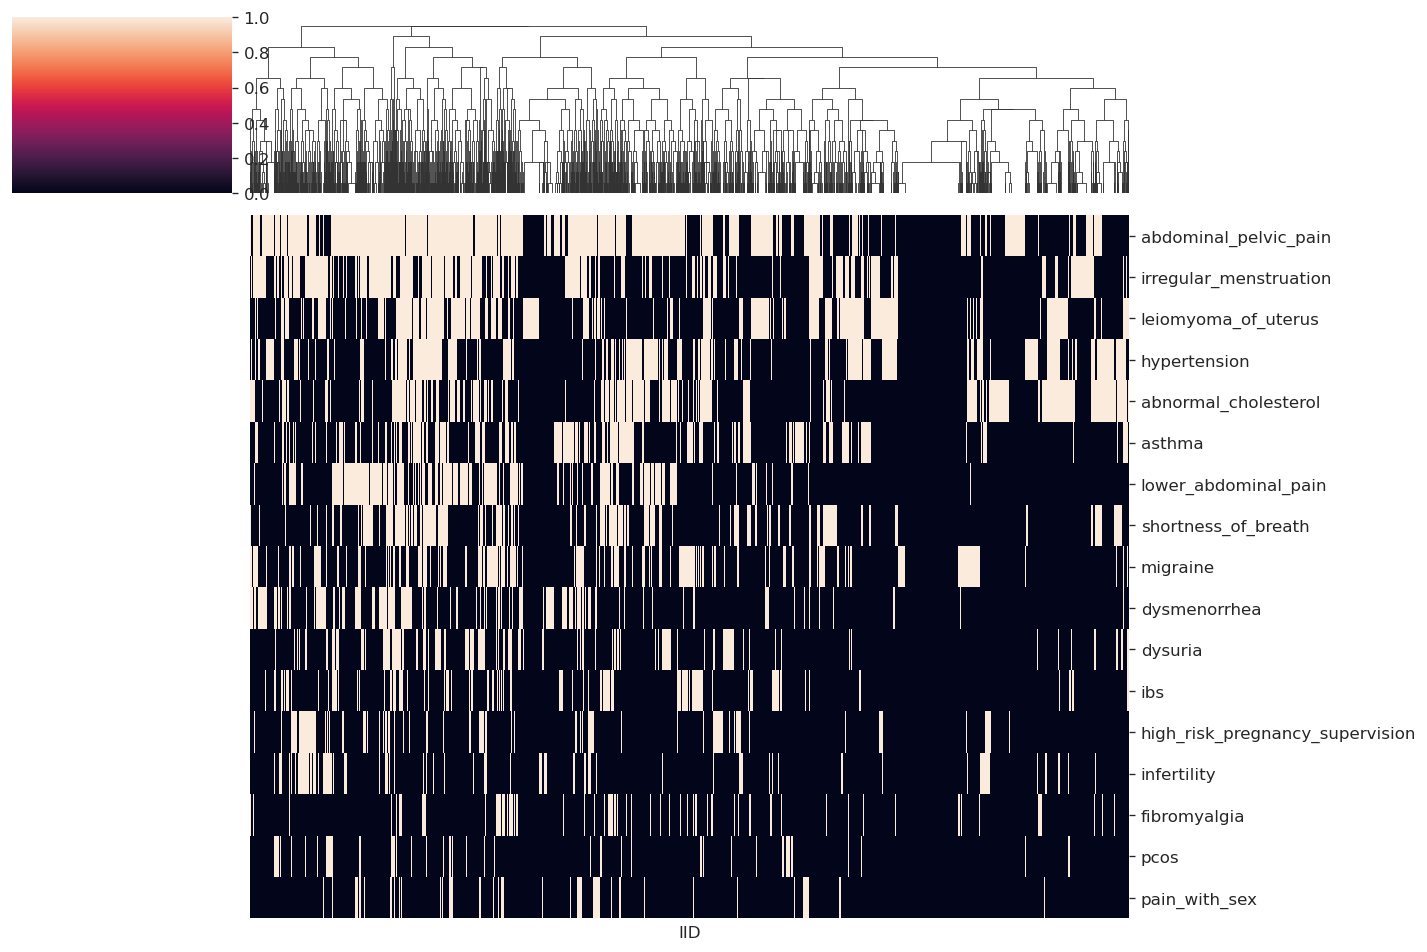

In [10]:
feature_order = features.mean().sort_values(ascending=False).index

sns.clustermap(features[feature_order].transpose(), method='complete', yticklabels=True, metric='cityblock', row_cluster=False, xticklabels=False)
plt.gcf().set_size_inches(12, 8)
plt.tight_layout()
plt.show()

                   PMBB2087149971253  PMBB2469756963210
IID                                                    
PMBB2087149971253           0.000000           0.047446
PMBB2469756963210           0.047446           0.000000
count    4078.000000
mean        0.369529
std         0.063459
min         0.270808
25%         0.317686
50%         0.364243
75%         0.409189
max         0.631337
dtype: float64
Index(['PMBB2751328733224', 'PMBB8667461338154', 'PMBB9452935005606'], dtype='object')
count    4075.000000
mean        0.369186
std         0.063228
min         0.270573
25%         0.317347
50%         0.363883
75%         0.409007
max         0.554796
dtype: float64


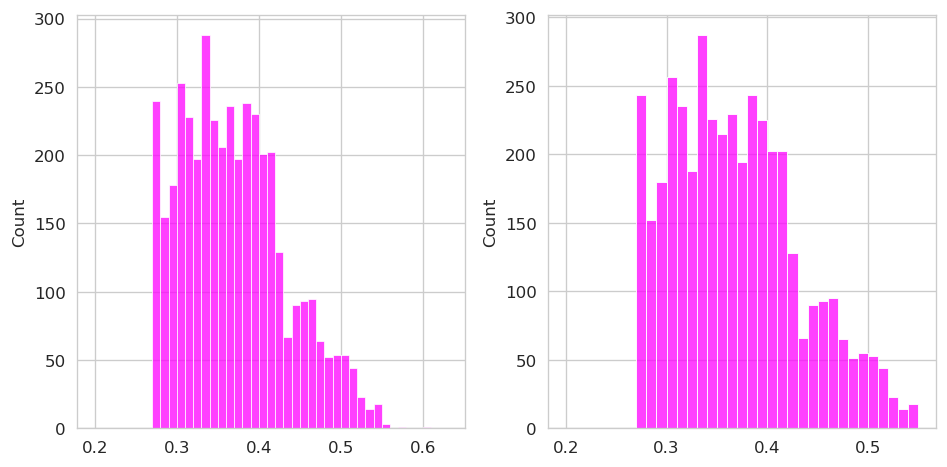

,PMBB1001462384555,PMBB1002857391938,PMBB1003210639911,PMBB1003222496744,PMBB1003626451826,PMBB1004325391026,PMBB1005252976083,PMBB1006656964324,PMBB1011916439505,PMBB1012175794211,...,PMBB9987252371205,PMBB9990373118350,PMBB9991089432357,PMBB9991448703098,PMBB9991994966750,PMBB9993259322112,PMBB9994756680249,PMBB9995182887713,PMBB9997370924922,PMBB9998857962671
IID,,,,,,,,,,,,,,,,,,,,,
PMBB1001462384555,0.000000,0.274475,0.421372,0.262558,0.114363,0.086084,0.108832,0.095676,0.161234,0.680873,...,0.354139,0.294028,0.136110,0.681266,0.193141,0.163581,0.181320,0.287952,0.245223,0.305364
PMBB1002857391938,0.274475,0.000000,0.621459,0.183897,0.360919,0.336496,0.250585,0.339113,0.200531,0.582361,...,0.595714,0.143621,0.290539,0.582725,0.256494,0.419828,0.290421,0.171726,0.498656,0.328688
PMBB1003210639911,0.421372,0.621459,0.000000,0.485917,0.337487,0.413890,0.380357,0.432962,0.569932,0.682193,...,0.161729,0.693686,0.530683,0.682491,0.374737,0.373856,0.580307,0.518496,0.262075,0.373558
PMBB1003222496744,0.262558,0.183897,0.485917,0.000000,0.320522,0.337812,0.188673,0.350932,0.298246,0.439665,...,0.502077,0.316392,0.355246,0.439999,0.117041,0.403526,0.380469,0.034958,0.437785,0.148494
PMBB1003626451826,0.114363,0.360919,0.337487,0.320522,0.000000,0.077880,0.132448,0.098363,0.244048,0.712267,...,0.251416,0.385016,0.193792,0.712635,0.225214,0.088934,0.243208,0.350414,0.138791,0.324334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PMBB9993259322112,0.163581,0.419828,0.373856,0.403526,0.088934,0.085138,0.215543,0.090166,0.267241,0.800444,...,0.252224,0.416717,0.190788,0.800811,0.312955,0.000000,0.234101,0.431964,0.123384,0.412710
PMBB9994756680249,0.181320,0.290421,0.580307,0.380469,0.243208,0.168327,0.256650,0.151651,0.099874,0.819487,...,0.481648,0.218358,0.058481,0.819882,0.353673,0.234101,0.000000,0.394189,0.354617,0.467438
PMBB9995182887713,0.287952,0.171726,0.518496,0.034958,0.350414,0.363546,0.218137,0.375600,0.308703,0.429309,...,0.535697,0.310393,0.372535,0.429654,0.150410,0.431964,0.394189,0.000000,0.470038,0.171897


In [11]:
tsne_dist_mtx = pd.read_csv('TSNE_Random_Avg_no_SNPs/avg_dist_mtx_0_200.csv', index_col='IID', dtype={'IID': str})

asymmetric = tsne_dist_mtx.loc[np.any(tsne_dist_mtx != tsne_dist_mtx.transpose(), axis=1),
                               np.any(tsne_dist_mtx != tsne_dist_mtx.transpose(), axis=0)]
print(asymmetric)

a_idx = asymmetric.index

# manually fix floating-point issues
for i, a1 in enumerate(asymmetric.index):
    for j, a2 in enumerate(asymmetric.index):
        if i >= j:
            continue
        tsne_dist_mtx.loc[a1, a2] = tsne_dist_mtx.loc[a2, a1]

# tsne_dist_mtx = pd.read_csv('PMBB/TSNE_Random_Avg_no_SNPs/avg_dist_mtx_0_200_KEEP_SAVE_061423.csv', index_col='IID', dtype={'IID': str})

fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(8, 4)

mean_dist = tsne_dist_mtx.mean()
print(mean_dist.describe())
sns.histplot(mean_dist, bins=np.arange(0.2, mean_dist.max(), 0.01), ax=axes[0])

outliers = mean_dist.index[mean_dist > (mean_dist.mean() + 3 * mean_dist.std())]
tsne_dist_mtx = tsne_dist_mtx.loc[[i for i in tsne_dist_mtx.index if i not in outliers],
                                  [c for c in tsne_dist_mtx.columns if c not in outliers]]

print(outliers)

mean_dist = tsne_dist_mtx.mean()
print(mean_dist.describe())
sns.histplot(mean_dist, bins=np.arange(0.2, mean_dist.max(), 0.01), ax=axes[1])
plt.tight_layout()
plt.show()

features = features[~features.index.isin(outliers)]
tsne_dist_mtx

In [12]:
! ls -lah Data/merged_k_tests_long.csv

-rw-rw---- 1 guarelin heromicslpc 78K Nov 17 13:29 Data/merged_k_tests_long.csv


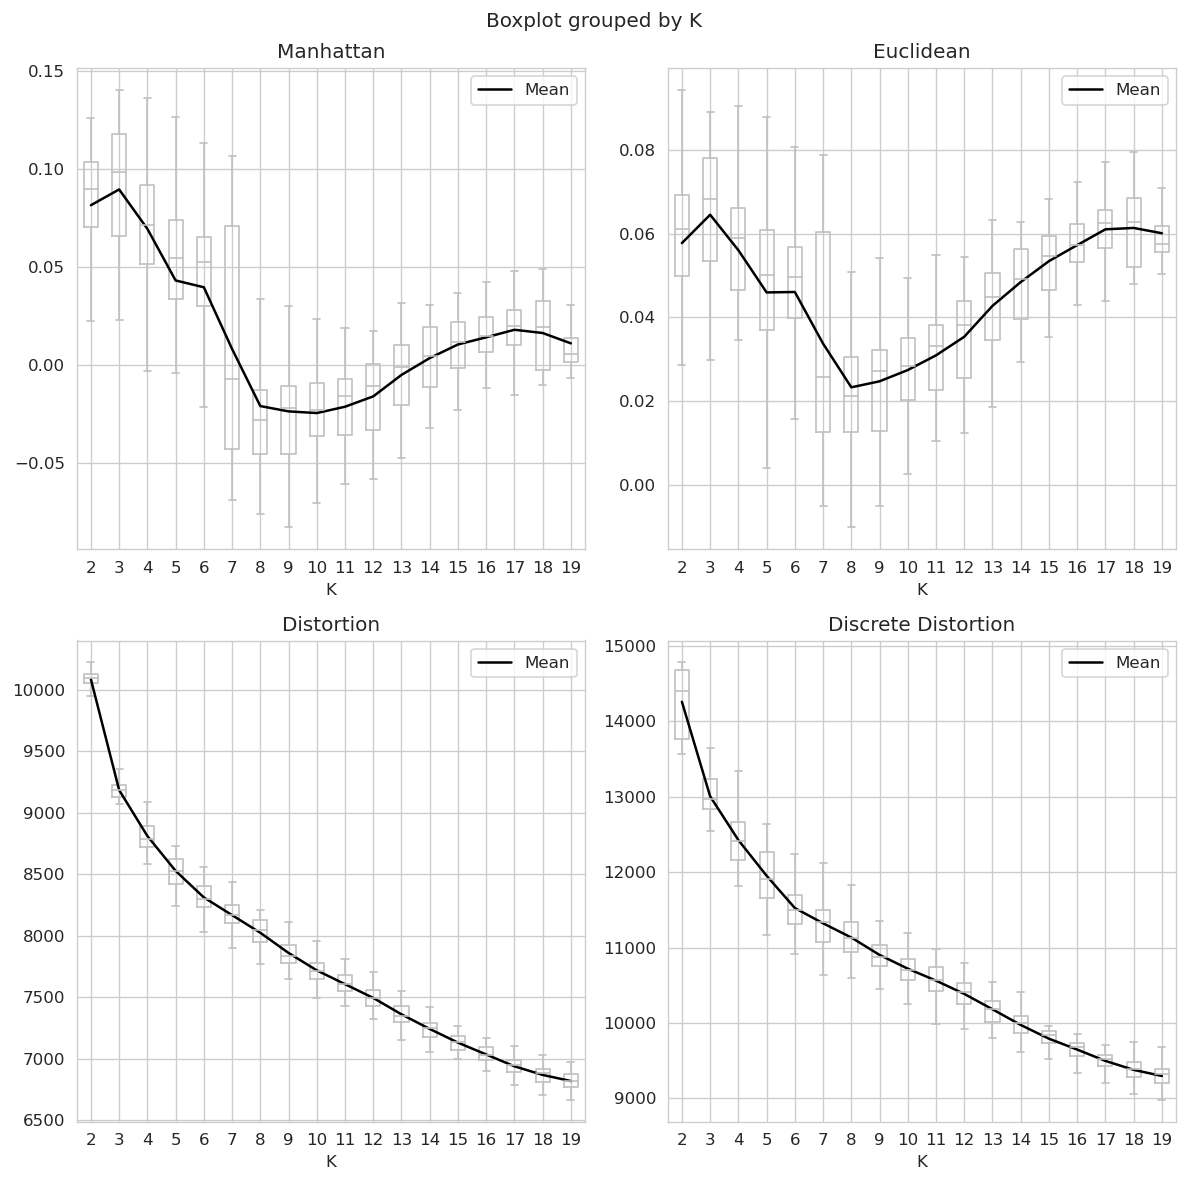

In [13]:
k_tests = pd.read_csv('Data/merged_k_tests_long.csv')

fig, axes = plt.subplots(ncols=2, nrows=2)

fig.set_size_inches(10, 10)

colorprops = {'boxes': 'silver',
              'whiskers': 'silver',
              'medians': 'silver',
              'caps': 'silver'}

k_tests.boxplot(['Manhattan'], by='K', showfliers=False, ax=axes[0][0], color=colorprops)
k_tests.boxplot(['Euclidean'], by='K', showfliers=False, ax=axes[0][1], color=colorprops)
k_tests.boxplot(['Distortion'], by='K', showfliers=False, ax=axes[1][0], color=colorprops)
k_tests.boxplot(['Discrete Distortion'], by='K', showfliers=False, ax=axes[1][1], color=colorprops)

axes[0][0].plot(np.arange(18)+1, k_tests.groupby('K')['Manhattan'].mean(), label='Mean', color='k')
axes[0][1].plot(np.arange(18)+1, k_tests.groupby('K')['Euclidean'].mean(), label='Mean', color='k')
axes[1][0].plot(np.arange(18)+1, k_tests.groupby('K')['Distortion'].mean(), label='Mean', color='k')
axes[1][1].plot(np.arange(18)+1, k_tests.groupby('K')['Discrete Distortion'].mean(), label='Mean', color='k')

for ax in axes.flatten():
    ax.legend()

plt.tight_layout()
plt.show()

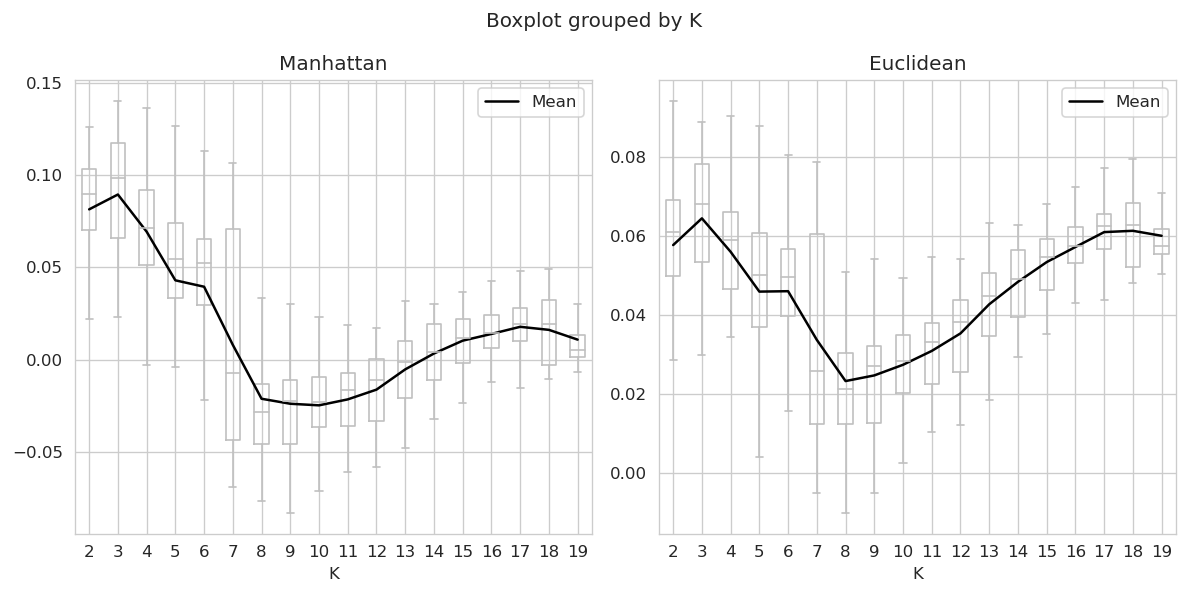

In [14]:
k_tests = pd.read_csv('Data/merged_k_tests_long.csv')

fig, axes = plt.subplots(ncols=2, nrows=1)

fig.set_size_inches(10, 5)

k_tests.boxplot(['Manhattan'], by='K', showfliers=False, ax=axes[0], color=colorprops)
k_tests.boxplot(['Euclidean'], by='K', showfliers=False, ax=axes[1], color=colorprops)

axes[0].plot(np.arange(18)+1, k_tests.groupby('K')['Manhattan'].mean(), label='Mean', c='k')
axes[1].plot(np.arange(18)+1, k_tests.groupby('K')['Euclidean'].mean(), label='Mean', c='k')

for ax in axes.flatten():
    ax.legend()

plt.tight_layout()
plt.show()

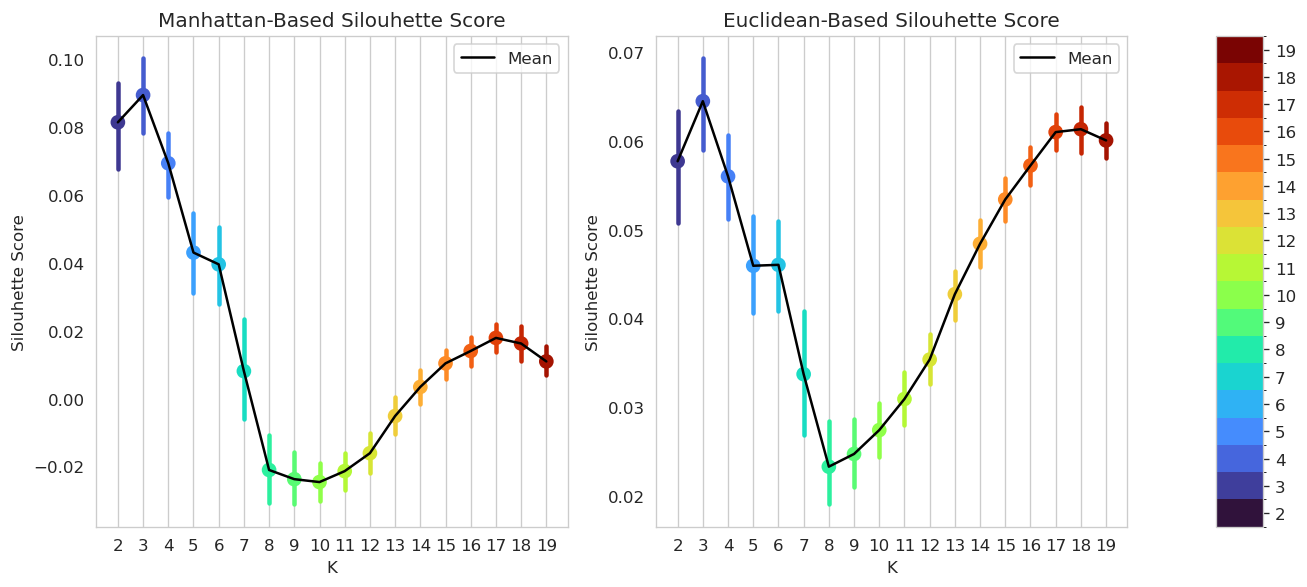

In [15]:
k_tests = pd.read_csv('Data/merged_k_tests_long.csv')

fig, axes = plt.subplots(ncols=3, nrows=1, gridspec_kw={'width_ratios': [1, 1, 0.1]})

fig.set_size_inches(11, 5)

sns.pointplot(data=k_tests, x='K', y='Manhattan', palette='turbo', ax=axes[0])
sns.pointplot(data=k_tests, x='K', y='Euclidean', palette='turbo', ax=axes[1])

# norm = mpl.colors.Normalize(vmin=2, vmax=19)
norm = mpl.colors.BoundaryNorm(np.arange(1.5, 20.5), ncolors=256)
sm = mpl.cm.ScalarMappable(norm, cmap='turbo')
plt.colorbar(sm, cax=axes[2])
axes[2].set_yticks(np.arange(2, 20))

axes[0].plot(np.arange(18), k_tests.groupby('K')['Manhattan'].mean(), label='Mean', c='k')
axes[1].plot(np.arange(18), k_tests.groupby('K')['Euclidean'].mean(), label='Mean', c='k')

axes[0].grid()
axes[1].grid()

axes[0].set_ylabel('Silouhette Score')
axes[1].set_ylabel('Silouhette Score')

axes[0].set_title('Manhattan-Based Silouhette Score')
axes[1].set_title('Euclidean-Based Silouhette Score')

for ax in axes[:2].flatten():
    ax.legend()

plt.tight_layout()
plt.savefig('Plots/pointplots_NG_PMBB_silouhette_scores_k_tests.png', bbox_inches='tight')
plt.show()

In [24]:
best_k = 3
k = 3
"""
model = AgglomerativeClustering(n_clusters=k,
                                affinity='precomputed',
                                linkage='complete')
"""

from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=3,random_state=314159, assign_labels='cluster_qr')

clusters = pd.Series(model.fit_predict(genes_factors), index=genes_factors.index)
print(clusters.value_counts().sort_index())

/home/guarelin/mambaforge/envs/py38/lib/python3.8/site-packages/sklearn/cluster/_spectral.py:658: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


KeyboardInterrupt: 

In [17]:
clusters.name = 'Cluster'
clusters.to_csv('Data/NG_PMBB_clusters.csv')

In [18]:
tsne = TSNE(n_components=2, init='pca', perplexity=50, random_state=314159, metric='manhattan')
embedding = pd.DataFrame(tsne.fit_transform(features),
                         columns=['TSNE 1', 'TSNE 2'],
                         index=features.index)

/home/guarelin/mambaforge/envs/py38/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/guarelin/mambaforge/envs/py38/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


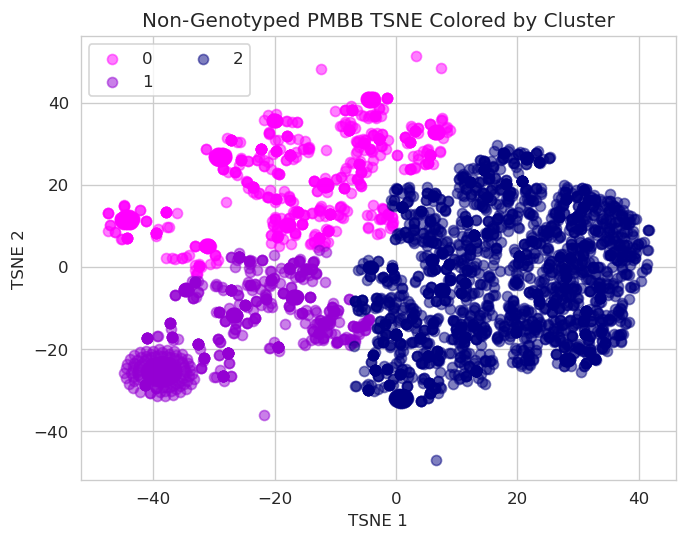

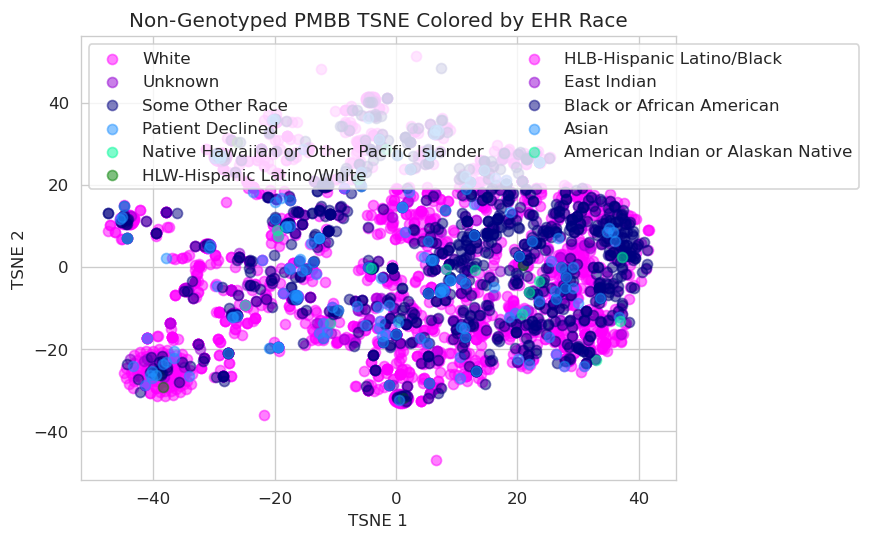

In [19]:
for cluster, subDF in embedding.groupby(clusters):
    plt.scatter(subDF['TSNE 1'], subDF['TSNE 2'], label=cluster, alpha=0.5)

plt.ylabel('TSNE 2')
plt.xlabel('TSNE 1')

plt.legend(loc='upper left', ncol=2)

plt.title('Non-Genotyped PMBB TSNE Colored by Cluster')
plt.savefig('Plots/no_snps_scatter_NG_PMBB_TSNE_Clusters.png', dpi=150, bbox_inches='tight')
plt.show()

"""
for cluster, subDF in embedding.groupby(real_clusters):
    plt.scatter(subDF['TSNE 1'], subDF['TSNE 2'], label=cluster, alpha=0.5)

plt.ylabel('TSNE 2')
plt.xlabel('TSNE 1')

plt.legend(loc='upper left', ncol=2)

plt.title('Non-Genotyped PMBB TSNE Colored by Cluster')
plt.show()
"""

race_order = pheno['RACE'].value_counts().sort_index(ascending=False).index

for cluster in race_order:
    subDF = embedding.loc[pheno[pheno['RACE'] == cluster].index.intersection(embedding.index)]
    plt.scatter(subDF['TSNE 1'], subDF['TSNE 2'], label=cluster, alpha=0.5)

plt.legend()
plt.ylabel('TSNE 2')
plt.xlabel('TSNE 1')

plt.legend(loc='upper left', ncol=2)

plt.title('Non-Genotyped PMBB TSNE Colored by EHR Race')
plt.savefig('Plots/no_snps_scatter_NG_PMBB_TSNE_Race.png', dpi=150, bbox_inches='tight')
plt.show()

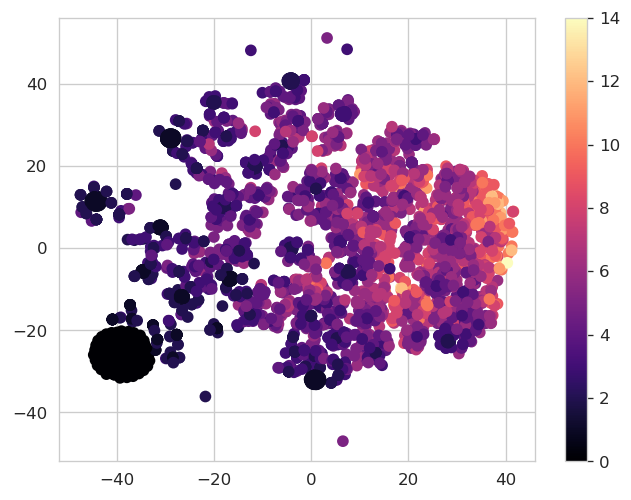

In [20]:
plt.scatter(embedding.loc[features.index, 'TSNE 1'],
            embedding.loc[features.index, 'TSNE 2'],
            c=features.sum(axis=1), cmap='magma')
plt.colorbar()
plt.show()

In [21]:
transfer_clusters = KNeighborsClassifier(n_neighbors=3, weights='distance',
                                         metric='manhattan', algorithm='brute')

transfer_clusters.fit(features.loc[clusters.index], clusters)

os.makedirs('Models/', exist_ok=True)
pickle.dump(transfer_clusters, open('Models/non_geno_PMBB_transfer_clusters.pickle', 'wb+'))

test_transfer = pickle.load(open('Models/non_geno_PMBB_transfer_clusters.pickle', 'rb'))
test_transfer.predict(features.loc[clusters.index])

training_y = transfer_clusters.predict(features.loc[clusters.index])

pd.crosstab(clusters, training_y)

col_0,0,1,2
Cluster,,,
0,967,0,0
1,0,800,0
2,0,0,2308


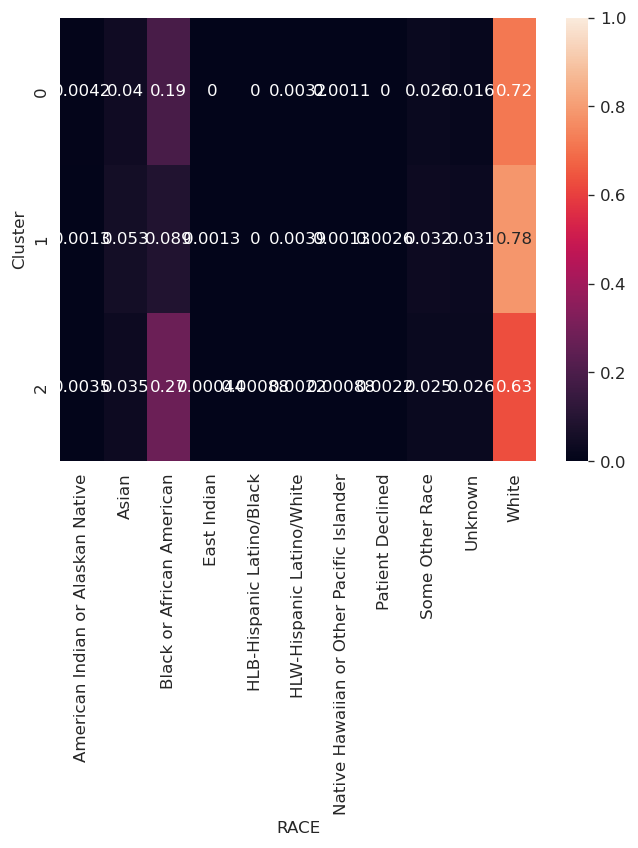

In [22]:
cluster_by_ancestry = pd.crosstab(pheno['RACE'], clusters)
cluster_by_ancestry.columns.name = 'Cluster'
sns.heatmap((cluster_by_ancestry / cluster_by_ancestry.sum()).transpose(),
            vmin=0, vmax=1, annot=True)
plt.show()